<a href="https://colab.research.google.com/github/DinaZakaria/AFLW2000_HeadPose/blob/master/Production_V02_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [84]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
import math
from skimage.io import imread, imsave
from google.colab import drive
import PIL.Image
from tensorflow.keras.preprocessing import image_dataset_from_directory
from skimage.io import imread, imsave
from glob import glob
import os
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import pandas as pd
from google.colab.patches import cv2_imshow
from imutils import face_utils
import argparse
import imutils
import dlib


## Connecting to Drive

In [85]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [86]:
Path = 'drive/My Drive/AI-Pro Track ITI/ML1/Project/Models/'
video_path =  'drive/My Drive/AI-Pro Track ITI/ML1/Project/Video/'

## Importing Models

In [87]:
# use joblib to save the model
import joblib

y_rf_model = joblib.load(Path + "rf_model_yaw_99.37.pkl")
r_svm_model = joblib.load(Path + "svm_model_roll_93.28.pkl")
p_svm_model = joblib.load(Path + "svm_model_pitch_92.12.pkl")


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator SVR from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your o

# Functions

## Dlib Face Detection

In [88]:
# initialize the Haar Cascade face detection model
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

In [89]:
# initialize dlib's face detector (HOG-based) and then create
# the facial landmark predictor
detector = dlib.get_frontal_face_detector()
# predictor = dlib.shape_predictor(args["shape_predictor"])
predictor = dlib.shape_predictor(Path + "shape_predictor_68_face_landmarks.dat")


In [90]:
def rect_to_bb(rect):
	# take a bounding predicted by dlib and convert it
	# to the format (x, y, w, h) as we would normally do
	# with OpenCV
	x = rect.left()
	y = rect.top()
	w = rect.right() - x
	h = rect.bottom() - y
	# return a tuple of (x, y, w, h)
	return (x, y, w, h)

In [91]:
def shape_to_np(shape, dtype="int"):
	# initialize the list of (x, y)-coordinates
	coords = np.zeros((68, 2), dtype=dtype)
	# loop over the 68 facial landmarks and convert them
	# to a 2-tuple of (x, y)-coordinates
	for i in range(0, 68):
		coords[i] = (shape.part(i).x, shape.part(i).y)
	# return the list of (x, y)-coordinates
	return coords

In [92]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [93]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data) 
  # grayscale img
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  print(gray.shape)
  # get face bounding box coordinates using Haar Cascade
  #faces = face_cascade.detectMultiScale(gray)
  # detect faces in the grayscale image
  faces = detector(gray, 1)
  # draw face bounding box on image
  # for (x,y,w,h) in faces:
  #     img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
  # loop over the face detections
  for (i, rect) in enumerate(faces):
	  # determine the facial landmarks for the face region, then
    # convert the facial landmark (x, y)-coordinates to a NumPy
    # array
    shape = predictor(gray, rect)
    shape = shape_to_np(shape)
    # convert dlib's rectangle to a OpenCV-style bounding box
    # [i.e., (x, y, w, h)], then draw the face bounding box
    (x, y, w, h) = face_utils.rect_to_bb(rect)
    cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
    # show the face number
    cv2.putText(img, "Face #{}".format(i + 1), (x - 10, y - 10),
      cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    # loop over the (x, y)-coordinates for the facial landmarks
    # and draw them on the image
    for (x, y) in shape:
      cv2.circle(img, (x, y), 1, (0, 0, 255), -1)
# show the output image with the face detections + facial landmarks
  # cv2_imshow("Output", img)
  # save image
  cv2.imwrite(filename, img)

  return filename, shape

In [94]:
def draw_axis(img, yaw, pitch, roll, tdx=None, tdy=None, roll_color = (255, 0, 0), yaw_color = (0, 255, 0),pitch_color = (0, 0, 255) ,size = 100):

    # pitch = pitch * np.pi / 180
    # yaw = -(yaw * np.pi / 180)
    # roll = roll * np.pi / 180
    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red -> pitch 
    x1 = size * (math.cos(yaw) * math.cos(roll)) + tdx
    y1 = size * (math.cos(pitch) * math.sin(roll) + math.cos(roll) * math.sin(pitch) * math.sin(yaw)) + tdy


    # Y-Axis | drawn in green -> yaw
    #        v
    x2 = size * (-math.cos(yaw) * math.sin(roll)) + tdx
    y2 = size * (math.cos(pitch) * math.cos(roll) - math.sin(pitch) * math.sin(yaw) * math.sin(roll)) + tdy


    # Z-Axis (out of the screen) drawn in blue -> roll
    x3 = size * (math.sin(yaw)) + tdx
    y3 = size * (-math.cos(yaw) * math.sin(pitch)) + tdy


    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),pitch_color,3)# -> pitch
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),yaw_color,3) # -> yaw
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),roll_color,2) # -> roll

    return cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

In [95]:
def pitch_calc(features):
  y_shift = 68
  XY = []
  xy_list = [8, 1, 15, 36, 33, 45, 48, 54, 51, 27, 39, 42, (8 + y_shift), (1+ y_shift), (15+ y_shift), (36+ y_shift), (33+ y_shift),(45+ y_shift), (48+ y_shift), (54+ y_shift), (51+ y_shift), (27 + y_shift), (39+ y_shift), (42+ y_shift)]
  x_list = [8, 1, 15, 36, 33, 45, 48, 54, 51, 27, 39, 42]
  y_list = [(8 + y_shift), (1+ y_shift), (15+ y_shift), (36+ y_shift), (33+ y_shift),(45+ y_shift), (48+ y_shift), (54+ y_shift), (51+ y_shift), (27 + y_shift), (39+ y_shift), (42+ y_shift)]
  XY_flatten = features.flatten()
  X_nose = XY_flatten[30]
  Y_nose = XY_flatten[30+68]
  X = features[0]
  Y = features[1]
  XY_min = [-194.634918,-638.594984,-279.565552,-183.654010,-11.746335,-143.268066,-136.300781,-51.043179,-25.957811,-48.235504,-98.102348,-90.383171,  -40.908096,-351.330231,-298.706635,-159.508102,-0.996384,-150.026917,-19.218119,-46.732491,-4.137651,-62.074074,-94.281723,-85.639481]

  XY_max = [250.905136,253.508972,605.936829,50.855518,9.373781,186.848282,46.432190,103.020767,19.463554,38.176659,58.384651,94.822937,  531.066570,328.824768,205.712341,131.862579,17.492509,29.623421,152.095271,154.862999,56.216815,6.602787,51.562538,-0.486808]
  X_ = XY_flatten[x_list]
  Y_ = XY_flatten[y_list]

  ad = np.sum(np.sqrt((X - X_nose)**2  + (Y - Y_nose)**2)) / features.shape[1]
  X_norm = np.sqrt((X - X_nose)**2  + (Y - Y_nose)**2) * (X - X_nose) / ad
  Y_norm = np.sqrt((X - X_nose)**2  + (Y - Y_nose)**2) * (Y - Y_nose) / ad
  X_norm = X_norm[x_list]
  Y_norm = Y_norm[x_list]
  XY.append(X_norm)
  XY.append(Y_norm)
  XY = np.array(XY)

  XY = XY.flatten()
  XY = (XY - np.array(XY_min))/(np.array(XY_max) - np.array(XY_min))


  #XY = XY/ (XY.max())
  #XY = (XY - XY.min())/ (XY.max() - XY.min())
  landmarks = XY.flatten()
  return landmarks 

In [96]:
def yaw_calc (features):
  y_shift = 68
  XY = []
  xy_list = y_shift = 68
  xy_list = [8, 36, 45, 48, 54, (8 + y_shift), (36+ y_shift), (45+ y_shift), (48+ y_shift), (54+ y_shift)]
  x_list = [8, 36, 45, 48, 54]
  y_list = [(8 + y_shift), (36+ y_shift), (45+ y_shift), (48+ y_shift), (54+ y_shift)]
  XY_flatten = features.flatten()
  X_nose = XY_flatten[30]
  Y_nose = XY_flatten[30+68]
  X = features[0]
  Y = features[1]
  XY_min = [-194.634918,-179.079529,-143.268066,-136.300781,-56.398777,5.828537,-159.508102,-164.334595,-19.218119,-10.380432]
  XY_max = [250.905136,61.430481,162.805283,65.533508,115.748909,271.105713,131.862579,63.464260,108.396553,74.616661]
  X_ = XY_flatten[x_list]
  Y_ = XY_flatten[y_list]

  ad = np.sum(np.sqrt((X - X_nose)**2  + (Y - Y_nose)**2)) / features.shape[1]
  X_norm = np.sqrt((X - X_nose)**2  + (Y - Y_nose)**2) * (X - X_nose) / ad
  Y_norm = np.sqrt((X - X_nose)**2  + (Y - Y_nose)**2) * (Y - Y_nose) / ad
  X_norm = X_norm[x_list]
  Y_norm = Y_norm[x_list]
  XY.append(X_norm)
  XY.append(Y_norm)
  XY = np.array(XY)

  XY = XY.flatten()
  XY = (XY - np.array(XY_min))/(np.array(XY_max) - np.array(XY_min))


  #XY = XY/ (XY.max())
  #XY = (XY - XY.min())/ (XY.max() - XY.min())
  landmarks = XY.flatten()
  return landmarks

In [97]:
def roll_calc(features):
  y_shift = 68
  XY = []
  xy_list = y_shift = 68
  xy_list = [8, 36, 45, 48, 54, (8 + y_shift), (36+ y_shift), (45+ y_shift), (48+ y_shift), (54+ y_shift)]
  x_list = [8, 36, 45, 48, 54]
  y_list = [(8 + y_shift), (36+ y_shift), (45+ y_shift), (48+ y_shift), (54+ y_shift)]
  XY_flatten = features.flatten()
  X_nose = XY_flatten[30]
  Y_nose = XY_flatten[30+68]
  X = features[0]
  Y = features[1]
  XY_min = [-152.439346,-179.079529,-56.122810,-136.300781,-51.043179,48.424305,-159.508102,-164.334595,-9.483962,-2.896796]
  XY_max = [186.068542,48.913834,162.805283,39.535946,115.748909,271.105713,24.273708,9.135871,108.396553,72.027794]
  X_ = XY_flatten[x_list]
  Y_ = XY_flatten[y_list]

  ad = np.sum(np.sqrt((X - X_nose)**2  + (Y - Y_nose)**2)) / features.shape[1]
  X_norm = np.sqrt((X - X_nose)**2  + (Y - Y_nose)**2) * (X - X_nose) / ad
  Y_norm = np.sqrt((X - X_nose)**2  + (Y - Y_nose)**2) * (Y - Y_nose) / ad
  X_norm = X_norm[x_list]
  Y_norm = Y_norm[x_list]
  XY.append(X_norm)
  XY.append(Y_norm)
  XY = np.array(XY)

  XY = XY.flatten()
  XY = (XY - np.array(XY_min))/(np.array(XY_max) - np.array(XY_min))


  #XY = XY/ (XY.max())
  #XY = (XY - XY.min())/ (XY.max() - XY.min())
  landmarks = XY.flatten()

  return landmarks

# Image Trails 

## Trail 1

<IPython.core.display.Javascript object>

(480, 640)
Saved to photo1.jpg


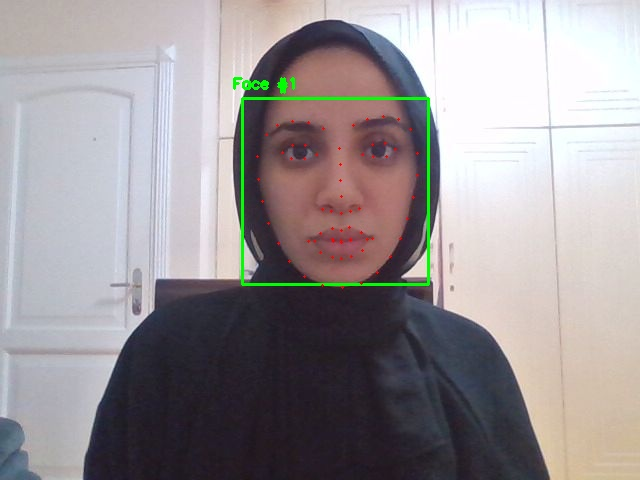

In [19]:
try:
  filename, shape = take_photo('photo1.jpg')
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

### Pitch

In [27]:
features = shape.T
pitch_landmarks=pitch_calc(features).reshape(1,-1)


In [28]:
label_P = p_svm_model.predict(pitch_landmarks)
label_P

array([0.04367134])

### Yaw

In [31]:
features = shape.T
yaw_landmarks=yaw_calc(features).reshape(1,-1)


In [32]:
label_y = y_rf_model.predict(yaw_landmarks)
label_y

array([-0.03099149])

### Roll

In [33]:
features = shape.T
roll_landmarks=roll_calc(features).reshape(1,-1)

In [34]:
label_r = r_svm_model.predict(yaw_landmarks)
label_r

array([-0.01064014])

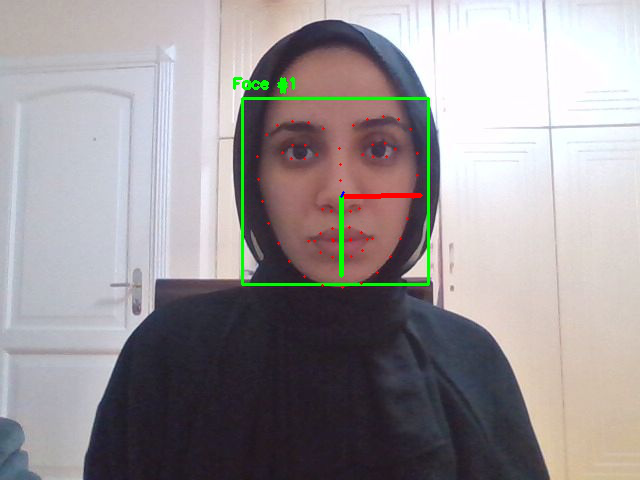

In [42]:
X_min = features [0].min()
X_max = features [0].max()
width = X_max-X_min 

img = imread("photo1.jpg")
X_nose = features.flatten()[30]
Y_nose = features.flatten()[30+68]
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = draw_axis( img, label_y, label_P, label_r, X_nose, Y_nose, roll_color = (0, 0, 255), yaw_color = (0, 255, 0),pitch_color = (255, 0, 0), size = width//2)
cv2_imshow(img)

## Trail 2

<IPython.core.display.Javascript object>

(480, 640)
Saved to photo1.jpg


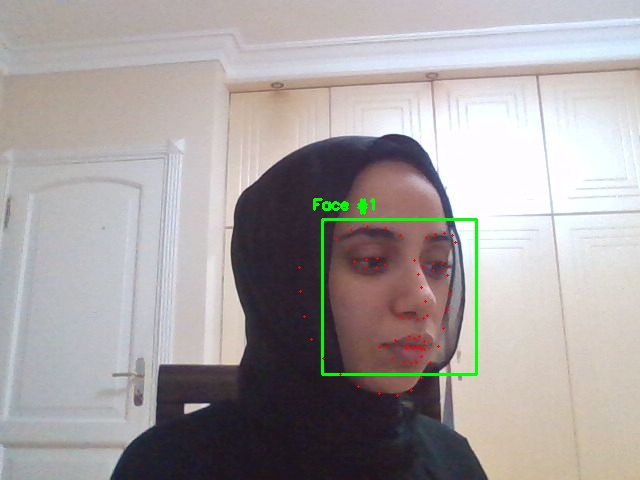

In [43]:
try:
  filename, shape = take_photo('photo1.jpg')
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

### Pitch

In [44]:
features = shape.T
pitch_landmarks=pitch_calc(features).reshape(1,-1)


In [45]:
label_P = p_svm_model.predict(pitch_landmarks)
label_P

array([0.24033229])

### Yaw

In [46]:
features = shape.T
yaw_landmarks=yaw_calc(features).reshape(1,-1)


In [47]:
label_y = y_rf_model.predict(yaw_landmarks)
label_y

array([-0.53138268])

### Roll

In [48]:
features = shape.T
roll_landmarks=roll_calc(features).reshape(1,-1)

In [49]:
label_r = r_svm_model.predict(yaw_landmarks)
label_r

array([0.15558172])

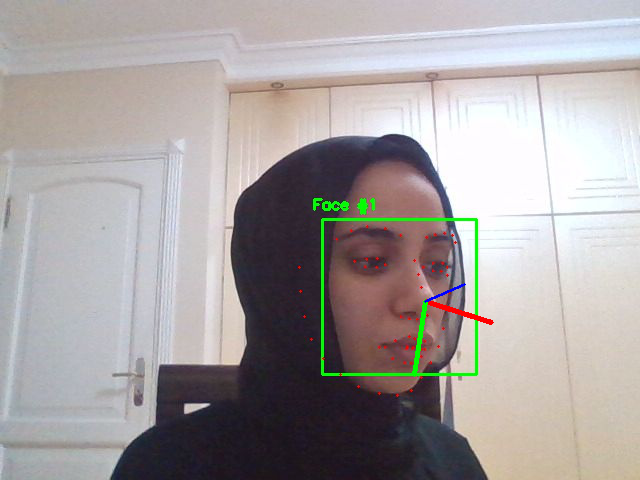

In [50]:
X_min = features [0].min()
X_max = features [0].max()
width = X_max-X_min 

img = imread("photo1.jpg")
X_nose = features.flatten()[30]
Y_nose = features.flatten()[30+68]
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = draw_axis( img, label_y, label_P, label_r, X_nose, Y_nose, roll_color = (0, 0, 255), yaw_color = (0, 255, 0),pitch_color = (255, 0, 0), size = width//2)
cv2_imshow(img)

## Trail 3

<IPython.core.display.Javascript object>

(480, 640)
Saved to photo1.jpg


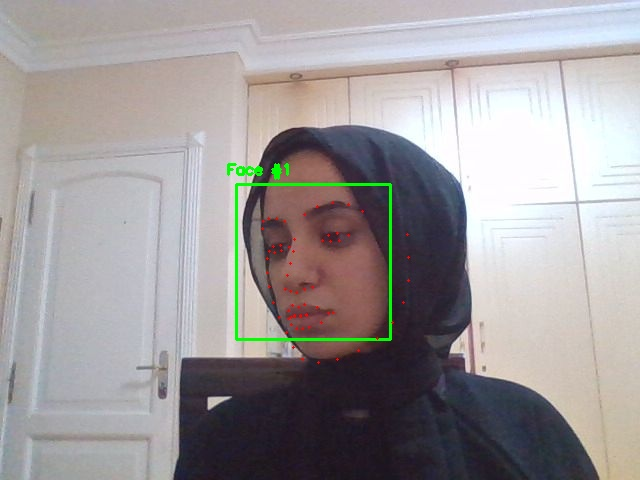

In [51]:
try:
  filename, shape = take_photo('photo1.jpg')
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

### Pitch

In [52]:
features = shape.T
pitch_landmarks=pitch_calc(features).reshape(1,-1)


In [53]:
label_P = p_svm_model.predict(pitch_landmarks)
label_P

array([-0.0051609])

### Yaw

In [54]:
features = shape.T
yaw_landmarks=yaw_calc(features).reshape(1,-1)


In [55]:
label_y = y_rf_model.predict(yaw_landmarks)
label_y

array([0.60552465])

### Roll

In [56]:
features = shape.T
roll_landmarks=roll_calc(features).reshape(1,-1)

In [57]:
label_r = r_svm_model.predict(yaw_landmarks)
label_r

array([-0.09752642])

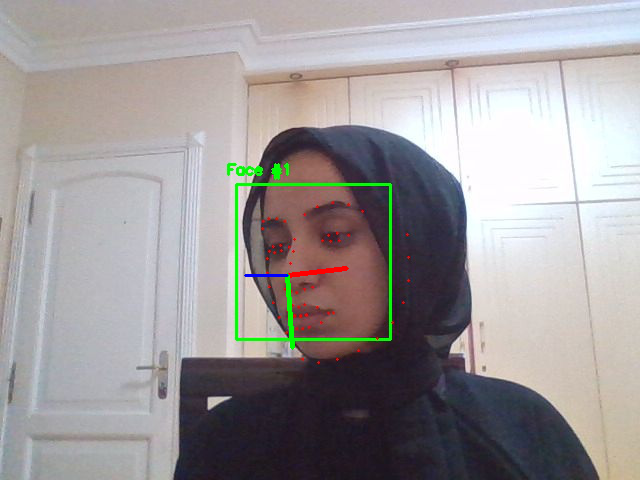

In [58]:
X_min = features [0].min()
X_max = features [0].max()
width = X_max-X_min 

img = imread("photo1.jpg")
X_nose = features.flatten()[30]
Y_nose = features.flatten()[30+68]
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = draw_axis( img, label_y, label_P, label_r, X_nose, Y_nose, roll_color = (0, 0, 255), yaw_color = (0, 255, 0),pitch_color = (255, 0, 0), size = width//2)
cv2_imshow(img)

## Trail 4

<IPython.core.display.Javascript object>

(480, 640)
Saved to photo1.jpg


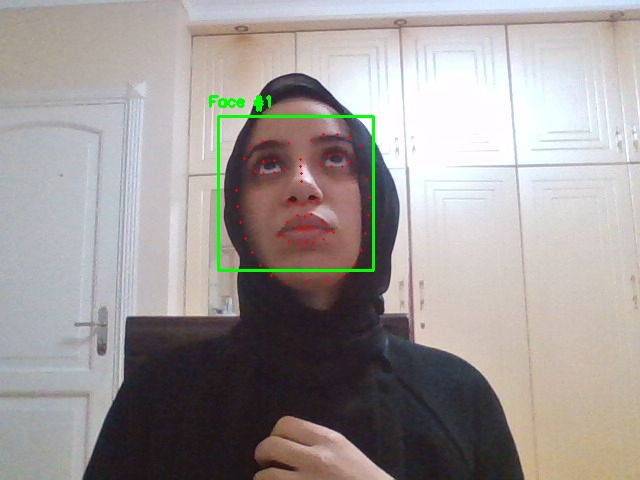

In [59]:
try:
  filename, shape = take_photo('photo1.jpg')
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

### Pitch

In [60]:
features = shape.T
pitch_landmarks=pitch_calc(features).reshape(1,-1)


In [61]:
label_P = p_svm_model.predict(pitch_landmarks)
label_P

array([0.42119381])

### Yaw

In [62]:
features = shape.T
yaw_landmarks=yaw_calc(features).reshape(1,-1)


In [63]:
label_y = y_rf_model.predict(yaw_landmarks)
label_y

array([0.12497336])

### Roll

In [64]:
features = shape.T
roll_landmarks=roll_calc(features).reshape(1,-1)

In [65]:
label_r = r_svm_model.predict(yaw_landmarks)
label_r

array([0.06912325])

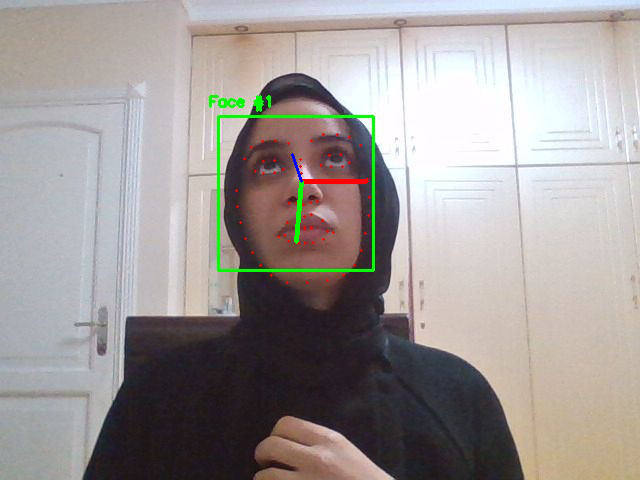

In [66]:
X_min = features [0].min()
X_max = features [0].max()
width = X_max-X_min 

img = imread("photo1.jpg")
X_nose = features.flatten()[30]
Y_nose = features.flatten()[30+68]
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = draw_axis( img, label_y, label_P, label_r, X_nose, Y_nose, roll_color = (0, 0, 255), yaw_color = (0, 255, 0),pitch_color = (255, 0, 0), size = width//2)
cv2_imshow(img)

## Trail 5

<IPython.core.display.Javascript object>

(480, 640)
Saved to photo1.jpg


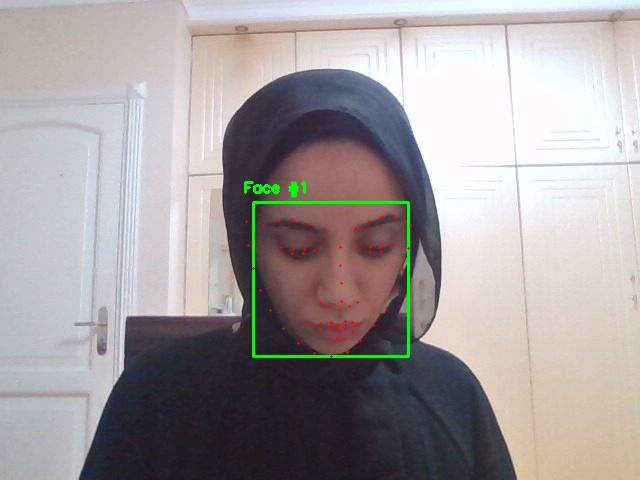

In [67]:
try:
  filename, shape = take_photo('photo1.jpg')
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

### Pitch

In [68]:
features = shape.T
pitch_landmarks=pitch_calc(features).reshape(1,-1)


In [69]:
label_P = p_svm_model.predict(pitch_landmarks)
label_P

array([-0.2858365])

### Yaw

In [70]:
features = shape.T
yaw_landmarks=yaw_calc(features).reshape(1,-1)


In [71]:
label_y = y_rf_model.predict(yaw_landmarks)
label_y

array([-0.12771472])

### Roll

In [72]:
features = shape.T
roll_landmarks=roll_calc(features).reshape(1,-1)

In [73]:
label_r = r_svm_model.predict(yaw_landmarks)
label_r

array([0.06154868])

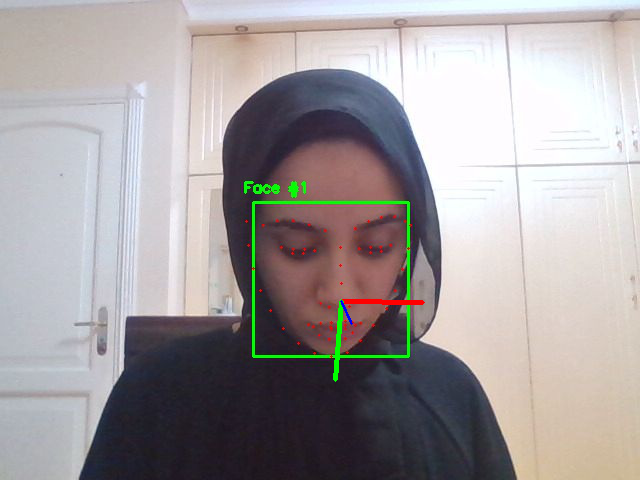

In [74]:
X_min = features [0].min()
X_max = features [0].max()
width = X_max-X_min 

img = imread("photo1.jpg")
X_nose = features.flatten()[30]
Y_nose = features.flatten()[30+68]
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = draw_axis( img, label_y, label_P, label_r, X_nose, Y_nose, roll_color = (0, 0, 255), yaw_color = (0, 255, 0),pitch_color = (255, 0, 0), size = width//2)
cv2_imshow(img)

## Video 

In [98]:
def read_video(videoInputPath):
  cap = cv2.VideoCapture(InputvideoPath)
  frames_array = []
  if (cap.isOpened()== False): 
    print("Error opening video stream or file")

  while (cap.isOpened()):
      ret, img = cap.read()
      if ret==False:
        break 
      frames_array.append(img)
  return frames_array

In [99]:
def video_write(videoOutputPath,frames_array):
  fourcc = cv2.VideoWriter_fourcc(*"MP4V")
  h, w, l = frames_array[0].shape 
  writer = cv2.VideoWriter(videoOutputPath, fourcc, 25.0,(w, h))

  for img in frames_array:  
    # draw face bounding box on image
    # grayscale image for face detection
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = detector(gray, 1)

    # loop over the face detections
    for (i, rect) in enumerate(faces):
      # determine the facial landmarks for the face region, then
      # convert the facial landmark (x, y)-coordinates to a NumPy
      # array
      shape = predictor(gray, rect)
      shape = shape_to_np(shape)
    features = shape.T 
    X_min = features [0].min()


    #drawing axes
    X_max = features [0].max()
    width = X_max-X_min 

    # predict pitch
    
    pitch_landmarks=pitch_calc(features).reshape(1,-1)
    label_P = p_svm_model.predict(pitch_landmarks)
    

    #predict yaw
    yaw_landmarks=yaw_calc(features).reshape(1,-1)
    label_y = y_rf_model.predict(yaw_landmarks)

    #predict roll
    roll_landmarks = roll_calc(features).reshape(1,-1)
    label_r = r_svm_model.predict(roll_landmarks)

    X_nose = features.flatten()[30]
    Y_nose = features.flatten()[30+68]
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = draw_axis( img, label_y, label_P, label_r, X_nose, Y_nose, (0,0,255),(0,255,0) ,(255,0,0) ,  width//2)
    writer.write(img)
  writer.release()


In [83]:
OutputvideoPath= video_path + "Output_video.mp4"
InputvideoPath=video_path +"Original_video.mp4"
print(InputvideoPath)
frames_array = read_video(InputvideoPath)
video_write(OutputvideoPath, frames_array)

drive/My Drive/AI-Pro Track ITI/ML1/Project/Video/Original_video.mp4
